In [109]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [110]:
env = BlackjackEnv()

In [111]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        # 'observation' is a tuple with 3 values
        gp = np.zeros(nA) # nA is 2
        
        # The non-greedy actions
        gp[:] = epsilon/nA 
        
        # The action with the highest value is the best action
        index_best_action = np.argmax(Q[observation])
        
        # The greedy action
        gp[index_best_action] = 1 - epsilon + epsilon/nA 

        return gp
        
    return policy_fn

In [60]:
#num_episodes
Q, policy = mc_control_epsilon_greedy(env, num_episodes = 1000, discount_factor=1.0, epsilon=0.1)
print(Q.items())
observation = env.reset()

print(observation, '\n (Score, dealer_score, Usable ace)')
print(np.argmax(Q[observation]))
#policy(observation)

dict_items([])
(19, 5, False) 
 (Score, dealer_score, Usable ace)
0


In [48]:
obs = (20,7, False)
Q = defaultdict(lambda: np.zeros(env.action_space.n))

print(env.action_space.n)
policy = make_epsilon_greedy_policy(Q, epsilon=0.1, nA = env.action_space.n)
print(policy(obs))

2
[0.95 0.05]


In [112]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    
    nbr_of_policy_improvement = 0
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        
        #action = np.random.randint(low=0, high=env.action_space.n)
        
        
        ###############################################################################################
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        while True:
            prob = policy(state) # The policy is implicitly updated here since we have updated Q
            # This is different from the psuedocode since they have exploring starts
            action = np.random.choice([0, 1], size=None, replace=True, p=prob) 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        ###############################################################################################
        # Find all states the we've visited in this episode
        # We convert each state-action pair to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            # Find the first occurance of the state-action pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state-action pair over all sampled episodes
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
            nbr_of_policy_improvement += 1
            
        # The policy is improved implicitly since we update Q
    return Q, policy, nbr_of_policy_improvement#, episode, states_in_episode

In [95]:
Q, policy
#, episode, states_in_episode = mc_control_epsilon_greedy(env, num_episodes = 2, discount_factor=1.0, epsilon=0.1)
print(Q.items())
print(policy)
#print(episode)
#print(states_in_episode)

dict_items([((16, 10, False), array([-0.57525773, -0.58004158])), ((19, 10, False), array([-0.09286328, -0.09380379])), ((17, 4, False), array([-0.09329446, -0.09202454])), ((15, 10, False), array([-0.57280928, -0.57644763])), ((14, 4, False), array([-0.27040816, -0.27226463])), ((16, 8, False), array([-0.54517134, -0.5566343 ])), ((14, 2, False), array([-0.24880383, -0.25      ])), ((13, 1, False), array([-0.72930649, -0.73444976])), ((21, 9, True), array([0.76712329, 0.73796791])), ((20, 10, False), array([0.26533907, 0.26395664])), ((18, 10, False), array([-0.30484988, -0.32128184])), ((13, 9, False), array([-0.5475    , -0.54663212])), ((16, 1, False), array([-0.72126437, -0.72206304])), ((13, 10, True), array([-0.43315508, -0.43243243])), ((21, 10, True), array([0.72857143, 0.72484848])), ((20, 9, False), array([0.60625   , 0.58810069])), ((14, 6, False), array([-0.22330097, -0.22613065])), ((18, 4, False), array([0.10060976, 0.09210526])), ((21, 10, False), array([0.77634409, 0.7

In [113]:
start = time.clock()

Q, policy, nbr_of_policy_improvement = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")
print(nbr_of_policy_improvement)

Episode 1000/500000.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 500000/500000.
 69.061952 s
630846


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


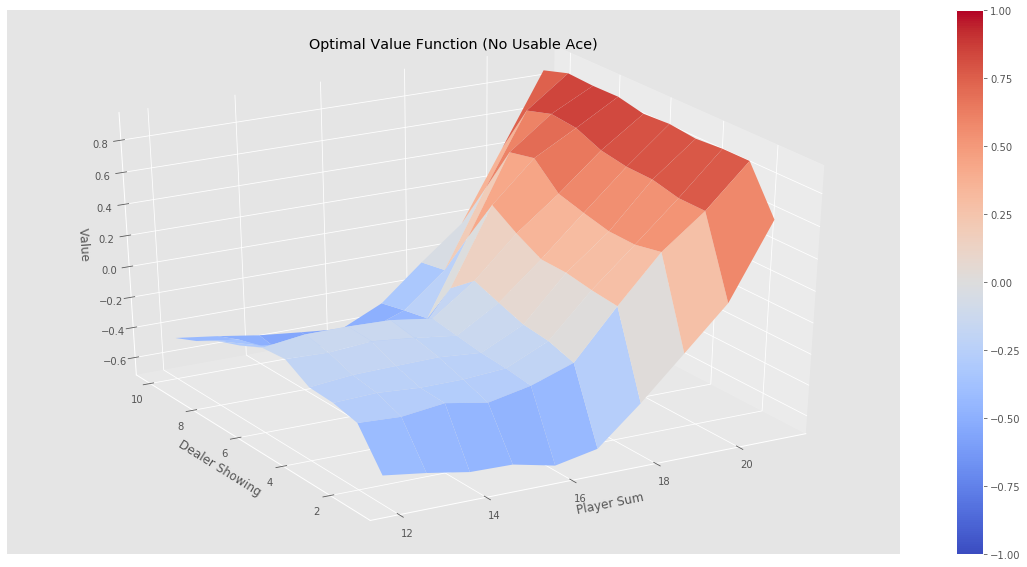

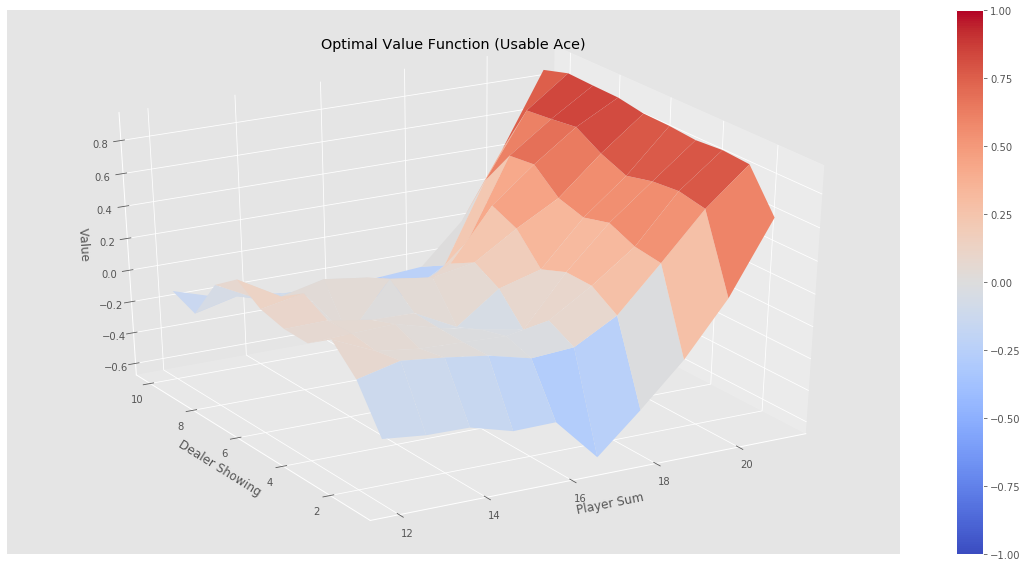

In [108]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")